In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize
from requests.auth import HTTPBasicAuth

from dotenv.main import load_dotenv
import os

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.tokenize import word_tokenize

import math

from sklearn.preprocessing import StandardScaler

import pickle


pd.options.display.max_seq_items = 20000
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 2000)

In [2]:
#Load the Api Key

from dotenv.main import load_dotenv
import os
load_dotenv()
API_KEY=os.environ["api_key"]

### 0.1 Notes and Thoughts

Hard Filters that are needed for the Dataset are:
- B2C
- Europe 
- (Later industry, first iteration without industry specificat)

All Available fields:
id
name
type
deleted
path
tagline
about
url,website_url,twitter_url,facebook_url,linkedin_url,google_url,crunchbase_url,angellist_url
playmarket_app_id,appstore_app_id
images
employees,employees_latest
industries,sub_industries,corporate_industries,service_industries
technologies
income_streams
growth_stage
traffic_summary
hq_locations
client_focus
revenues
tags
ownerships
delivery_method
launch_year,launch_month
has_promising_founder,has_strong_founder,has_super_founder
total_funding,total_funding_source,last_funding,last_funding_source
company_status,last_updated,last_updated_utc,created_utc
facebook_likes_chart,twitter_tweets_chart,twitter_followers_chart,twitter_favorites_chart
employees_chart
similarweb_3_months_growth_unique,similarweb_3_months_growth_percentile,similarweb_3_months_growth_relative,similarweb_3_months_growth_delta,similarweb_6_months_growth_unique,similarweb_6_months_growth_percentile,similarweb_6_months_growth_relative,similarweb_6_months_growth_delta,similarweb_12_months_growth_unique,similarweb_12_months_growth_percentile,similarweb_12_months_growth_relative,similarweb_12_months_growth_delta

app_3_months_growth_unique,app_3_months_growth_percentile,app_3_months_growth_relative,app_6_months_growth_unique,app_6_months_growth_percentile,app_6_months_growth_relative,app_12_months_growth_unique,app_12_months_growth_percentile,app_12_months_growth_relative,employee_3_months_growth_unique

employee_3_months_growth_percentile,employee_3_months_growth_relative,employee_3_months_growth_delta,employee_6_months_growth_unique,employee_6_months_growth_percentile,employee_6_months_growth_relative,employee_6_months_growth_delta,employee_12_months_growth_unique,employee_12_months_growth_percentile,employee_12_months_growth_relative,employee_12_months_growth_delta
kpi_summary
team
investors
fundings
traffic
similarweb_chart
job_openings
exits
trading_multiple
app_downloads_ios_chart,app_downloads_android_chart,app_downloads_ios_incremental_chart,app_downloads_android_incremental_chart
tech_stack_predictleads
sustainable_development_goals
core_side_value
data_type
pic_number
patents_count


### 0.2 Getting Available Filters for the Post Requests

In [13]:

api_url="https://api.dealroom.co/api/v1/companies/filters"
auth=HTTPBasicAuth(API_KEY, '')

headers = {'Content-Type': 'application/json'}
data={"fields":"launch_year",
              "limit": 1,
              "offset": 0
             }
response = requests.post(api_url,data=json.dumps(data),auth=auth,headers=headers)
data=response.json()
data


{'items': [{'key': 'launch_year',
   'items': [{'name': 2015, 'count': 84428, 'active': False},
    {'name': 2016, 'count': 79905, 'active': False},
    {'name': 2014, 'count': 78033, 'active': False},
    {'name': 2017, 'count': 76987, 'active': False},
    {'name': 2018, 'count': 72786, 'active': False},
    {'name': 2013, 'count': 72307, 'active': False},
    {'name': 2019, 'count': 70111, 'active': False},
    {'name': 2012, 'count': 68638, 'active': False},
    {'name': 2020, 'count': 62577, 'active': False},
    {'name': 2011, 'count': 58574, 'active': False},
    {'name': 2010, 'count': 55740, 'active': False},
    {'name': 2009, 'count': 47019, 'active': False},
    {'name': 2008, 'count': 40888, 'active': False},
    {'name': 2021, 'count': 38431, 'active': False},
    {'name': 2007, 'count': 37924, 'active': False},
    {'name': 2006, 'count': 33857, 'active': False},
    {'name': 2005, 'count': 30052, 'active': False},
    {'name': 2004, 'count': 27257, 'active': False},
   

# 1.1 Building the Core DF

1. Variables for the DF:

1.1: Independent Variables
- Team
- patents (patents_count)
- Round (fundings)
- Investors
- employees (latest, chart)
- Num. Investors (investors)
- (Industry Category) (industries)
- Description Length (about)
- Has Domain (website_url)
- Has Facebook (facebook_url)
- Has Twitter (twitter_url)
- Has LinkedIn (linkedin_url)
- Geographical Region (country, city/-code) (hq_locations)
- Total Funding (total_funding) (in mio)

1.2 Dependent Variables:
- Stage


Goal:
Predict possibility of follow on funding within the time frame of 3 years
Alternative: Predict possibility of funding, fail, acquisition, public

Rows that are dropped with empty values in following columns:
1. Web Url 
    avoid ghost companies
2. ownerships 
    bootstraped companies will not have funding information, thus not a missing value
    also essential for dependend variable
3. company status
    little info missing
4. launch year
    essential to project data to past


Open Questions:
- Should there be a difference between companies that are bootstrapped and dont want a funding or companies that are bootstrapped and dont get one
    - the later should realise through company failing

### Importing the Json file through according API Call:

In [1]:
import time
import requests
from requests.auth import HTTPBasicAuth
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [5]:
fields="id,name,about,tagline,investors,industries,website_url,facebook_url,twitter_url,linkedin_url,hq_locations,total_funding,company_status,ownerships,team,fundings,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal"
api_url="https://api.dealroom.co/api/v1"
api_key = API_KEY  # Replace with the issued Dealroom API key
AUTH = HTTPBasicAuth(api_key, "")
HEADERS = {'Content-Type': 'application/json'}

json_list=[]
k=0

# Set the parameters depending on the use case. See refs:
# https://urllib3.readthedocs.io/en/latest/reference/urllib3.util.html#module-urllib3.util.retry
retry_strategy = Retry(
    backoff_factor=1,
    total=3,
    read=3,
    status_forcelist=[500, 502, 503, 504],
    method_whitelist=False, # This is important to force retry of POST requests
)
ADAPTER = HTTPAdapter(max_retries=retry_strategy)

def get_session() -> requests.Session:
    """Return a Session object initialized with correct parameters."""

    session = requests.Session()
    session.headers = HEADERS
    session.auth = AUTH
    session.mount(api_url, ADAPTER)
    return session


def post_request(
        session: requests.Session,
        url: str,
        data: dict
    ) -> requests.models.Response:
    """Make a POST request using input Session object. If ConnectionError is
    raised, we refresh the session."""

    try:
        return session.post(url, json=data)

    except requests.exceptions.ConnectionError as exc:
        exc_str = f"{exc.__class__.__name__}: {exc}"
        print(f"POST request raised: {exc_str}. Refreshing session.")
        session = get_session()
        return session.post(url, json=data)


def get_response_body(response: requests.models.Response) -> dict:
    """Get response body. If JSONDecodeError is raised, returns an empty
    dictionary."""

    try:
        return response.json()

    except json.JSONDecodeError as exc:
        exc_str = f"{exc.__class__.__name__}: {exc}"
        print(f"Getting response body raised: {exc_str}. Returning empty dictionary.")
        return {}

if __name__ == "__main__":

    session = get_session()
    url = f"{api_url}/companies/bulk"

    next_page_id = ''

    while True:
        data = {
            'form_data': {'must':{'hq_locations': ['Europe'], 'client_focus':['business']}},
            'fields': fields,
            'next_page_id': next_page_id,
            'limit': 100,
            }
        
        r = post_request(session, url, data)
        res = get_response_body(r)
        json_list.append(res)
        k+=1
        if (k/10).is_integer():
            print(k,end="\r")


        next_page_id = res['next_page_id']
        if next_page_id is None:
            break
        
            
            
 

/var/folders/k0/ldv3tm456fl7jrgd0xn0vy5h0000gn/T/ipykernel_58424/955448161.py:12: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


In [ ]:
with open("second_json.json", "w") as fp:
        json.dump(json_list, fp)

In [10]:
f=open("/Users/klaus/Documents/Jarvis/Second Try/Data/first_json.json")
json_list=json.load(f)

In [3]:
a=open("/Users/klaus/Documents/Jarvis/Second Try/second_json.json")
json_list=json.load(a)

In [4]:
len(json_list)

2236

### 1.2 Converting Json to Pandas DF

In [5]:
df_list=[]
for i in range(len(json_list)):
    df_1=pd.json_normalize(json_list[i]["items"],sep="_").drop(columns=["hq_locations","industries"])
    df_1[["country_name","city_name"]]=pd.json_normalize(json_list[0]["items"],"hq_locations")[["country.name","city.name"]]
    df_1["industry_name"]=pd.json_normalize(json_list[0]["items"],"industries")["name"]
    df_list.append(df_1)

In [6]:
df=pd.concat(df_list)

In [7]:
df.shape

(223589, 25)

## 1.3 DataCleaning

In [8]:
x=df.isna().sum()
y=df.isna().sum()/len(df)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)


                  Missing Values  In percent
id                             0    0.000000
name                           0    0.000000
about                      57706   25.808962
tagline                    63161   28.248706
website_url                  619    0.276847
facebook_url              176873   79.106307
twitter_url               113788   50.891591
linkedin_url               50601   22.631256
total_funding                  0    0.000000
company_status                84    0.037569
ownerships                     0    0.000000
patents_count                  0    0.000000
employees_latest           59754   26.724928
employees_chart                0    0.000000
launch_year                34791   15.560247
dealroom_signal           178534   79.849188
investors_items                0    0.000000
investors_total                0    0.000000
team_items                     0    0.000000
team_total                     0    0.000000
fundings_items                 0    0.000000
fundings_t

In [9]:
df.dropna(subset=["website_url"],inplace=True) #companies without website will be deleted to avoid ghost companies
df.dropna(subset=["company_status"],inplace=True)#companies without status (only 84 so can be dismissed)
df.dropna(subset=["launch_year"],inplace=True)#without launch year dismissed as we want to put df into past

### Number of Empty lists as entries

In [11]:
for i,row in missing_values.iterrows():
    try:
        print(i,df[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df)*100,"%")
    except:
        None



name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 50.39079507683159 %
employees_chart 19.92311531640596 %
investors_items 72.00452387779158 %
team_items 53.53042998077883 %
fundings_items 71.93443563031636 %
industry_name 0.0 %


In [18]:
df_own=df.loc[df["ownerships"].apply(lambda x:True if len(x) == 0 else False)]
df_own.shape


(94903, 25)

The following shows us, that companies where the ownership field is empty have almost no information disclosed. Thus, they cannot possibly fall under any category necessary for defining the dependent variable. We will leave them out

In [14]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_own[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_own)*100,"%")
    except:
        None

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 100.0 %
employees_chart 40.0 %
investors_items 95.0 %
team_items 100.0 %
fundings_items 100.0 %
country_name 0.0 %
industry_name 0.0 %


In [26]:
df_1=df.loc[df["ownerships"].apply(lambda x:False if len(x) == 0 else True)]

In [99]:
df_1.loc[df_1["ownerships"].apply(lambda x: True if (len(x)==2 and x[1]=="bootstrapped")  else False),"ownerships"]=["bootstrapped"]*3167 #number of rows that fall in this category

Series([], Name: ownerships, dtype: object)

In [27]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_1[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_1)*100,"%")
    except:
        None  

print(df_1.shape)

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 11.410559664351233 %
investors_items 60.80744078517837 %
team_items 16.801703931243377 %
fundings_items 52.972782053065906 %
industry_name 0.0 %
(93431, 25)


### looking at rows where team is missing

In [28]:
df_team=df_1[df_1["team_items"].apply(lambda x:True if len(x) == 0 else False)]

In [30]:
df_team.head()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name
3,2176609,LNS,LNS brings over 45 years of proven experience ...,Discover the LNS Difference in your Country,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,acquired,[Private Equity],7,31.0,"[{'date': '2019-07-01', 'value': 25}, {'date':...",1973.0,None,"[{'id': 2914933, 'name': 'Storskogen', 'path':...",1,[],0,"[{'id': 539414, 'year': 2021, 'month': 12, 'am...",1,Switzerland,Orvin,semiconductors
45,2207899,Smartseq,None,SmartSeq - NGS Bioinformatics Services,http://www.smartseq.it/,None,None,None,0.0,acquired,[Subsidiary],0,NaN,[],2013.0,None,"[{'id': 1472687, 'name': 'Enne3', 'path': 'enn...",2,[],0,"[{'id': 546441, 'year': 2022, 'month': 2, 'amo...",1,Italy,NaN,food
35,2249339,Ekomi,"We believe in the power of authentic, more and...",eKomi | The Feedback Company,http://ekomi.nl,None,https://twitter.com/ekomi,https://www.linkedin.com/company/ekomi/,0.0,operational,[bootstrapped],0,191.0,"[{'date': '2018-12-01', 'value': 196}, {'date'...",2008.0,None,[],0,[],0,[],0,Slovenia,NaN,marketing
60,2091408,Scoriff,Scoriff is a new-age business credit scoring c...,Behavioral business credit scoring | We apply ...,http://scoriff.com,https://www.facebook.com/scoriff,None,https://www.linkedin.com/company/scoriff/,0.0,operational,"[Venture Capital, accelerator]",0,1.0,"[{'date': '2021-03-30', 'value': 1}, {'date': ...",2018.0,None,"[{'id': 15975, 'name': 'Startup Wise Guys', 'p...",1,[],0,"[{'id': 404409, 'year': 2019, 'month': 4, 'amo...",1,Denmark,NaN,music
90,2119636,PDFlib,None,None,http://pdflib.com,None,None,None,0.0,acquired,[Subsidiary],3,NaN,[],2000.0,None,"[{'id': 227558, 'name': 'PDFTron', 'path': 'pd...",1,[],0,"[{'id': 648576, 'year': 2022, 'month': 7, 'amo...",1,Switzerland,NaN,media


In [29]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_team[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_team)*100,"%")
    except:
        None  

print(df_team.shape)

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 30.169448337367815 %
investors_items 47.39457255701363 %
team_items 100.0 %
fundings_items 28.889030449738822 %
industry_name 0.0 %
(15698, 25)


No need to drop columns where team items are missing

### We observe that many of the empty lists for fundings and investors are for bootstrapped startups. It makes sense to distinguish between those where data is missing and those where it simply makes no sense to have data

In [40]:
df_invest=df_1.loc[df_1["investors_items"].apply(lambda x:True if len(x) == 0 else False)]
df_boots=df_invest.loc[df_invest["ownerships"].apply(lambda x:True if ((x[0]=="bootstrapped" and len(x)<=1) or (x==["not known","bootstrapped"]) or (x[0]=="not known")) else False)]

df_boots["investors_items"].values[:]=["boots"]

df_2=pd.concat([df_1,df_boots])

df_2.drop_duplicates(subset=["id"],keep="last", inplace=True)

In [44]:
df_2.tail()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name
77,30064,Silicon Canals,Silicon Canals was founded in 2014 by Remco Ja...,"News, knowledge, and insights from the Europea...",https://siliconcanals.com/,https://www.facebook.com/siliconcanals,https://twitter.com/siliconcanals,https://www.linkedin.com/company/silicon-canals,0.0,operational,[bootstrapped],0,6.0,"[{'date': '2020-02-25', 'value': 5}, {'date': ...",2014.0,NaN,boots,0,"[{'id': 1180, 'name': 'Remco Janssen', 'path':...",8,[],0,Netherlands,NaN,travel
79,2568210,Databrydge,Databrydge koppelt eenvoudig online (financiël...,None,http://databrydge.com,None,None,https://www.linkedin.com/company/databrydge/,0.0,operational,[bootstrapped],0,6.0,"[{'date': '2021-06-24', 'value': 6}, {'date': ...",2017.0,NaN,boots,0,"[{'id': 4392662, 'name': 'John Schrijvers', 'p...",1,[],0,Belgium,Liège,robotics
81,2303255,Vosesoftware,Vose Software is a specialist risk software fi...,Enterprise risk management | ERM & risk softwa...,http://vosesoftware.com,None,None,https://www.linkedin.com/company/vose-software/,0.0,operational,[bootstrapped],0,4.0,"[{'date': '2021-07-18', 'value': 4}, {'date': ...",2005.0,NaN,boots,0,"[{'id': 4393402, 'name': 'Stijn Vanden Bossche...",1,[],0,Cyprus,Limassol Municipality,fintech
83,4257253,Anabar,Who we are \n\nAnabar is an analytics system f...,Automates work with goods on marketplaces and ...,http://anabar.ai,None,None,https://www.linkedin.com/company/anabar/,0.0,operational,[not known],0,14.0,"[{'date': '2022-09-16', 'value': 9}, {'date': ...",2020.0,NaN,boots,0,[],0,"[{'id': 657907, 'year': 2022, 'month': 3, 'amo...",1,Serbia,NaN,enterprise software
88,4257225,DataGrowb',La DATA et l’IA (Intelligence Artificielle) so...,A company at the forefront of innovations and ...,http://datagrowb.com,None,None,https://www.linkedin.com/company/datagrowb/,0.0,operational,[not known],0,8.0,"[{'date': '2022-08-11', 'value': 9}, {'date': ...",2018.0,NaN,boots,0,[],0,"[{'id': 663320, 'year': 2021, 'month': 12, 'am...",3,Denmark,NaN,enterprise software


In [45]:
df_fundings=df_2.loc[df_2["fundings_items"].apply(lambda x:True if len(x) == 0 else False)]
df_fundinv=df_fundings.loc[df_fundings["investors_items"].apply(lambda x:True if x == "boots" else False)] #take only those from where investors are missing, as the missing funding with existing investors hints towards missing data
df_s=df_fundinv.loc[df_fundinv["ownerships"].apply(lambda x:True if ((x[0]=="bootstrapped" and len(x)<=1) or (x==["not known","bootstrapped"]) or (x[0]=="not known")) else False)]

df_s["fundings_items"].values[:]=["boots"]

df_3=pd.concat([df_2,df_s])

df_3.drop_duplicates(subset=["id"],keep="last", inplace=True)

In [47]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_3[i].apply(lambda x:1 if len(x)==0 else 0).sum()/len(df_3)*100,"%")
    except:
        print(i,"0.0%")
        

id 0.0%
name 0.0 %
about 0.0%
tagline 0.0%
website_url 0.0 %
facebook_url 0.0%
twitter_url 0.0%
linkedin_url 0.0%
total_funding 0.0%
company_status 0.0 %
ownerships 0.0 %
patents_count 0.0%
employees_latest 0.0%
employees_chart 11.410559664351233 %
launch_year 0.0%
dealroom_signal 0.0%
investors_items 7.046911624621378 %
investors_total 0.0%
team_items 16.801703931243377 %
team_total 0.0%
fundings_items 1.2961436782224314 %
fundings_total 0.0%
country_name 0.0%
city_name 0.0%
industry_name 0.0 %


Data Seems quite clean to me. No more Data Cleaning Needed 

### 1.3 Unravel nested Data to generate Present Dataset

For the following we want to extract the nested data and retreive the information we need
First we extract investors types

In [15]:
def level1_extractor_list(x,field):
    try:
        a=list(pd.json_normalize(x)[field])
    except:
        a=[]
    return a

def level1_extractor_max(x,field):
    try:
        a=max(list(pd.json_normalize(x)[field]))
    except:
        a=[]
    return a

def level2_extractor_list(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=list([c for b in list(mp) if len(b)!=0 for c in b])
    except:
        a=[]
    return a

def level2_extractor_max(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=max([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

def level2_extractor_min(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=min([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

def level2_extractor_avg(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=np.mean([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

Export Feature of Universities at which team members studies

In [452]:
a=map(lambda p: level2_extractor_list(p, "universities.items","university.name"), df_3["team_items"])
b=list(a)

df_3["team_universities"]=b

Export Features of Investor Types

In [421]:
a=map(lambda p: level1_extractor_list(p, "type"), df_3["investors_items"])
b=list(a)
df_3["investors_types"]=b


Export Features of Valuation

In [29]:
a=map(lambda p: level1_extractor_list(p, "valuation_generated_max"), df_3["fundings_items"])
b=list(a)
df_3["list_valuation"]=b
df_3["last_valuation"]=list(map(lambda p: p[0] if len(p)!=0 else  None,df_3["list_valuation"]))
df_3.drop(columns="list_valuation",inplace=True)

NameError: name 'df_3' is not defined

Get Number of Female and Number of Male Founder

In [36]:
a=map(lambda p: level1_extractor_list(p, "gender"), df_3["team_items"])
b=list(a)
df_3["team_gender"]=b
df_3["team_male"]=list(map(lambda p: p.count("male"),df_3["team_gender"]))
df_3["team_female"]=list(map(lambda p: p.count("female"),df_3["team_gender"]))
df_3.drop(columns="team_gender",inplace=True)

Turning url's to the binary (0-has no url, 1-has url)

### Spliting the Data into on dataframe from 3 years ago and today

First lets try to exclude all companies that have been founded in the between time

- Variables that need to be included
0. Number Employees (maybe include growth over the past two to four entries) + growth
1. Team universities (num of top degrees)
2. Gender of Team
3. Stage of company
4. max valuation (would not yet include)
5. investors total (hohe korrelation mit fundings)
6. fundings total
7. total funding
8. company status 
9. Missing values
10. Avg time between funding
11. Employee History
12. Is bootstrapped (dummy)

?Do we need the ownership collumn?

In [14]:
def level1_extractor_list_past(x,year_field,year,field):
    try:
        a=pd.json_normalize(x)
        a=list(a[a[year_field]<=year][field])
    except:
        a=[]
    return a

def level2_extractor_list_past1(x,year_field,year,field1,field2):
    try:
        first=pd.json_normalize(x)
        first=first[first[year_field]<=year][field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=[x for x in list(mp) if x!=None]
    except:
        a=[]
    return a

def level2_extractor_list_past2(x,year_field,year,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list_past(p,year_field,year, field2), first)
        a=[x for x in list(mp) if x!=None]
    except:
        a=[]
    return a

Get DF copy with companies launched before 2020

In [49]:
df_past=df_3[df_3["launch_year"]<=2020].copy()
df_past.shape

(90331, 25)

In [6]:
df_past=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_past_29.11.22")

In [7]:
df_past.shape

(90331, 27)

### Feature Engineering

0. Number of Employees / Avg Growth

In [21]:
a=map(lambda p: level1_extractor_list_past(p,"date","2020-01-01","value"), df_past["employees_chart"])
b=list(a)
df_past["employees_latest"]=b
df_past["employees_growth"]=df_past["employees_latest"].apply(lambda x: np.mean((np.array(x[1:len(x)])-np.array(x[0:len(x)-1]))/np.array(x[0:len(x)-1])) if len(x)!=0 else None)
df_past["employees_latest"]=df_past["employees_latest"].apply(lambda x: x[-1] if len(x)!=0 else None)


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Founder Background info

In [4]:
df_past["founder_id"]=df_past["team_items"].map(lambda p: level1_extractor_list(p, "id"))


NameError: name 'df_past' is not defined

In [6]:
b=df_past["founder_id"]

In [16]:
b[1:10]

/var/folders/k0/ldv3tm456fl7jrgd0xn0vy5h0000gn/T/ipykernel_10766/574538588.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  b[1:10]


5     [2178577, 2519258, 4202289]
26                      [2977160]
45                             []
60                             []
90                             []
98                             []
20                             []
6                       [3588231]
41                             []
Name: founder_id, dtype: object

In [5]:
a=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/founder_backgr_772")

In [22]:
unique_companies=pd.unique([item for b in a for item in b])

In [31]:
# should include good investors, universities and companies
filter_list=univ_wanted # comes from below

In [6]:
import os

In [63]:
with open('df_past_29.11.22', 'wb') as f: 
        pickle.dump(df_past, f)

In [6]:
b=df_past["founder_id"]
len(b)

90331

In [3]:
df_past=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_past_29.11.22")

391,773

In [7]:
b=df_past["founder_id"]
k_start=0
k=881
a=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/founder_backgr_{}".format(k-1))
for i in range(k*100,len(b),100):
    info=b.iloc[i:i+100].map(lambda p: founders_info(p))
    a.extend(info) 
    with open('founder_backgr_{}'.format(k), 'wb') as f: # data of founder background gathering until k
        pickle.dump(a, f)
    if k!=k_start:
        os.remove('founder_backgr_{}'.format(k-1))
    k+=1
    print(k,end="\r") # prints chunk it is working on next. If stopped, start from here
return a 

SyntaxError: 'return' outside function (1019271122.py, line 14)

In [9]:
df_past["founders_background"]=a

In [10]:
df_founder=pd.DataFrame({'id':b, 'background':a})
df_founder.to_pickle("df_founder_backgr")

In [5]:
def founders_info(id):
    l=[]
    for i in id:
        if (len(id)!=0):
            try: 
                api_url="https://api.dealroom.co/api/v1/founders/{}".format(i)
                auth=HTTPBasicAuth(API_KEY, '')

                headers = {
                    "Content-Type": "application/json",
                    "Authorization": "Basic undefined"
                }

                response = requests.get(url=api_url, auth=auth, headers=headers)

                res=json.loads(response.text)
                a=pd.json_normalize(res)
                a=pd.json_normalize(a["companies.items"][0])["name"]
                l.extend(list(a))
            except: None
        else: 
            l=[]
    return l




Investor Names

In [20]:
pd.json_normalize(df_past.iloc[0]["investors_items"])

,id,name,path,type,url,exited,images.32x32,images.74x74,images.100x100
0,2914933,Storskogen,storskogen,fund,https://app.dealroom.co/investors/storskogen,False,https://s3-eu-west-1.amazonaws.com/dealroom-im...,https://s3-eu-west-1.amazonaws.com/dealroom-im...,https://s3-eu-west-1.amazonaws.com/dealroom-im...


In [25]:
a=map(lambda p: level1_extractor_list(p, "name"), df_past["investors_items"])
b=list(a)

df_past["investor_names"]=b
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"investor_names"]="boots"

In [23]:
inv_list1=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/europe ranking.csv")
inv_list2=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/Investor top ranking - Sheet1.csv",names=["NAME"])
inv_wanted=pd.concat([inv_list1,inv_list2],ignore_index=True).NAME



In [26]:
a=[]
for i in range(len(b)):
    if len(b[i])!=0:
        a.extend(b[i])
a=pd.unique(a)
inv_filter=[x for x in a if process.extractOne(x.lower(), inv_wanted, scorer=fuzz.token_sort_ratio)[-2]>=99]

In [27]:
a=map(lambda p: len([x for x in p if x in inv_filter]), df_past.investor_names)
b=list(a)
df_past["number_top_inv"]=b

1. Team Universities

I will include all universities at this point despite the position the person has. I believe that even a software developer that graduated from a good school has a positive impact on the company. This is also an indicator that the startup is able to attract top talent

In [23]:
a=map(lambda p: level2_extractor_list(p, "universities.items","university.name"), df_past["team_items"])
b=list(a)

df_past["team_universities"]=b

In [24]:
univ_list=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/Data/universities_lists_dataviz.csv")
univ_wanted=univ_list["University"]
univ_wanted=univ_wanted.append(pd.Series(["Insead","University of Cambridge","Stockholm University","London School of Economics and Political Science","KTH Royal Institute of Technology","Technical University Munich","University of Oxford","University of St. Gallen","HEC Paris","Copenhagen Business School","WHU – Otto Beisheim School of Management","IESE Business School","IE Business School","Cranfield","ESMT Berlin","Esade","Technical University Berlin","EU Business School","Delft University of Technology","Harbour.Space University","KTH Royal Institute of Technology","Vlerick","Trinity College School","Politecnico di Milano","The University of Manchester","Lund University","University of Edinburgh","The University of Groningen","Jönköping University"]))

/var/folders/k0/ldv3tm456fl7jrgd0xn0vy5h0000gn/T/ipykernel_41288/3555416957.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  univ_wanted=univ_wanted.append(pd.Series(["Insead","University of Cambridge","Stockholm University","London School of Economics and Political Science","KTH Royal Institute of Technology","Technical University Munich","University of Oxford","University of St. Gallen","HEC Paris","Copenhagen Business School","WHU – Otto Beisheim School of Management","IESE Business School","IE Business School","Cranfield","ESMT Berlin","Esade","Technical University Berlin","EU Business School","Delft University of Technology","Harbour.Space University","KTH Royal Institute of Technology","Vlerick","Trinity College School","Politecnico di Milano","The University of Manchester","Lund University","University of Edinburgh","The University of Groningen","Jönköping University"]))


In [25]:
a=[]
for i in range(len(b)):
    if len(b[i])!=0:
        a.extend(b[i])
a=pd.unique(a)
univ_filter=[x for x in a if process.extractOne(x.lower(), univ_wanted, scorer=fuzz.token_sort_ratio)[-2]>=90]

In [27]:
a=map(lambda p: len([x for x in p if x in univ_filter]), df_past.team_universities)
b=list(a)
df_past["number_top_schools"]=b

In [28]:
a=map(lambda p: len(p), df_past.team_universities)
b=list(a)
df_past["number_schools"]=b

2. Gender of Team

Only include the gender of the top Exec's

In [34]:
a=[]
b=map(lambda p: level2_extractor_list(p,"titles","name"),df_past["team_items"])
b=list(b)

In [35]:
for i in range(len(b)):
    if len(b[i])!=0:
        a.extend(b[i])
a=pd.unique(a)

In [36]:
titles_wanted=["ceo","cfo","cto","chief","founder","officer","leader","owner"]
titles_filter=[x for x in a if process.extractOne(x.lower(), titles_wanted, scorer=fuzz.token_sort_ratio)[-1]>=60]


In [37]:
def level1_extractor_list_gender(x,titles_wanted):
    try:
        a=pd.json_normalize(x)
        a["title_name"]=list(map(lambda p: level1_extractor_list(p,"name"),a["titles"]))
        try:
            a=a[a["title_name"].apply(lambda x:True if (len(x)!=0 and x[0] in titles_filter) else False)]
        except:
            None
        a=list(a["gender"])        
    except:
        a=None
    return a

In [38]:
a=map(lambda p: level1_extractor_list_gender(p, titles_filter), df_past["team_items"])
b=list(a)

df_past["gender"]=b

In [39]:
df_past["team_male"]=list(map(lambda p: p.count("male") if p is not None  else 0,df_past["gender"]))
df_past["team_female"]=list(map(lambda p: p.count("female") if p is not None else 0,df_past["gender"]))
df_past.drop(columns="gender",inplace=True)

In [40]:
df_past.head()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,employees_growth,founder_id,founders_background,investor_names,team_universities,number_top_schools,number_schools,team_male,team_female,Fin.Round.past,Fin.Round.now,avg_time_funding,company_status_past,Y,is_bootstrapped,number_top_inv,cteam,missing_values
0,2176609,LNS,LNS brings over 45 years of proven experience ...,Discover the LNS Difference in your Country,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0,acquired,[Private Equity],7,27.0,"[{'date': '2019-07-01', 'value': 25}, {'date':...",1973.0,None,"[{'id': 2914933, 'name': 'Storskogen', 'path':...",1,[],0,"[{'id': 539414, 'year': 2021, 'month': 12, 'am...",0,Switzerland,Orvin,semiconductors,0.080000,[],None,[Storskogen],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,1.0,2
1,2178401,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,Develop best-in-class nanomedicines for Fluore...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000,closed,"[Venture Capital, accelerator]",0,NaN,[],2018.0,None,"[{'id': 901563, 'name': 'EIT Health e.V.', 'pa...",3,"[{'id': 2178577, 'name': 'James Collins', 'pat...",3,"[{'id': 526542, 'year': 2019, 'month': 2, 'amo...",3,Switzerland,Renens,health,NaN,"[2178577, 2519258, 4202289]","[ALAnostics, ALAnostics, MassChallenge, Ventur...","[EIT Health e.V., MassChallenge, Venture Kick]","[University of Ljubljana, Université Paris Cit...",0,3,2,0,"[SEED, GRANT]","[SEED, GRANT]",0.333333,closed,failed,0,0,1.0,2
2,2156990,Stragen Chemical,Focusing on innovation for health solutions si...,Stragen Pharma SA - Innovation Health and Expe...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0,acquired,[Private Equity],0,118.0,"[{'date': '2018-12-01', 'value': 130}, {'date'...",1990.0,None,"[{'id': 923712, 'name': 'ArchiMed', 'path': 'a...",1,"[{'id': 2977160, 'name': 'Philippe Bordeau', '...",1,"[{'id': 456300, 'year': 2021, 'month': 6, 'amo...",0,Switzerland,NaN,health,-0.015919,[2977160],"[Alaxia, Stragen Chemical]",[ArchiMed],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,NaN,3
3,2207899,Smartseq,None,SmartSeq - NGS Bioinformatics Services,http://www.smartseq.it/,None,None,None,0,acquired,[Subsidiary],0,NaN,[],2013.0,None,"[{'id': 1472687, 'name': 'Enne3', 'path': 'enn...",2,[],0,"[{'id': 546441, 'year': 2022, 'month': 2, 'amo...",0,Italy,NaN,food,NaN,[],None,"[Enne3, Devyser]",None,0,0,0,0,[],[ACQUISITION],NaN,operational,acquired,0,0,1.0,6
4,2091408,Scoriff,Scoriff is a new-age business credit scoring c...,Behavioral business credit scoring | We apply ...,http://scoriff.com,https://www.facebook.com/scoriff,None,https://www.linkedin.com/company/scoriff/,0,operational,"[Venture Capital, accelerator]",0,NaN,"[{'date': '2021-03-30', 'value': 1}, {'date': ...",2018.0,None,"[{'id': 15975, 'name': 'Startup Wise Guys', 'p...",1,[],0,"[{'id': 404409, 'year': 2019, 'month': 4, 'amo...",1,Denmark,NaN,music,NaN,[],None,[Startup Wise Guys],None,0,0,0,0,[SEED],[SEED],1.000000,operational,0,0,1,1.0,5


3. Get Company Stage

In [117]:
a=map(lambda p: level1_extractor_list_past(p,"year",2020,"round"), df_past["fundings_items"])
b=list(a)
df_past["Fin.Round.past"]=b
df_past["Fin.Round.past"]=list(map(lambda p: p[0:2] if len(p)!=0 else  p,df_past["Fin.Round.past"]))
a=map(lambda p: level1_extractor_list(p,"round"), df_past["fundings_items"])
b=list(a)
df_past["Fin.Round.now"]=b
df_past["Fin.Round.now"]=list(map(lambda p: p[0:2] if len(p)!=0 else  p,df_past["Fin.Round.now"]))
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"Fin.Round.now"]="boots"
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"Fin.Round.past"]="boots"


In [46]:
for i in df_past.columns:
    try:
        print(i,df_past[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_past)*100,"%")
    except:
        None

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 11.54531666869624 %
investors_items 6.940031661334426 %
team_items 16.867963379127872 %
fundings_items 1.26756041668973 %
industry_name 0.0 %
founder_id 16.867963379127872 %
founders_background 16.87349857745403 %
investor_names 60.77537058152793 %
team_universities 45.246925197329816 %
Fin.Round.past 58.467192879520866 %
Fin.Round.now 53.060411154531664 %


5. Fundings Total /avg time between funding

In [208]:
def level1_extractor_shape_past(x,year_field,year):
    try:
        a=pd.json_normalize(x)
        a=a[a[year_field]<=year].shape[0]
    except:
        a=None
    return a
a=map(lambda p: level1_extractor_shape_past(p,"year",2020) , df_past["fundings_items"])
b=list(a)
df_past["fundings_total"]=b

df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"fundings_total"]=0

In [268]:
a=map(lambda p: (level1_extractor_list_past(p,"year",2020,"year")), df_past["fundings_items"])
b=list(a)
df_past["avg_time_funding"]=b

def avg_time(x,y):
    if len(x)==1:
        avg_fund=x[0]-y
    elif len(x)>1:
        dif=np.array(x[0:len(x)-1])-np.array(x[1:len(x)])
        avg_fund=(np.mean(np.append(dif,x[len(x)-1]-y))) # will add time to first funding to even it out with companies that had one funding
    else:
        avg_fund=0

    return avg_fund
        
a=map(avg_time,df_past["avg_time_funding"],df_past["launch_year"])
df_past["avg_time_funding"]=list(a)

In [269]:
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"avg_time_funding"]=0

7. Total funding

In [44]:
a=map(lambda p: level1_extractor_list_past(p,"year",2020,"amount_source"), df_past["fundings_items"])
b=list(a)
df_past["total_funding"]=b
#df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"total_funding"]=0

In [50]:
df_past.head()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,employees_growth,founder_id,founders_background,investor_names,team_universities,number_top_schools,number_schools,team_male,team_female,Fin.Round.past,Fin.Round.now,avg_time_funding,company_status_past,Y,is_bootstrapped,number_top_inv,cteam,missing_values
0,2176609,LNS,LNS brings over 45 years of proven experience ...,Discover the LNS Difference in your Country,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,acquired,[Private Equity],7,27.0,"[{'date': '2019-07-01', 'value': 25}, {'date':...",1973.0,None,"[{'id': 2914933, 'name': 'Storskogen', 'path':...",1,[],0,"[{'id': 539414, 'year': 2021, 'month': 12, 'am...",0,Switzerland,Orvin,semiconductors,0.080000,[],None,[Storskogen],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,NaN,3
1,2178401,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,Develop best-in-class nanomedicines for Fluore...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000.0,closed,"[Venture Capital, accelerator]",0,NaN,[],2018.0,None,"[{'id': 901563, 'name': 'EIT Health e.V.', 'pa...",3,"[{'id': 2178577, 'name': 'James Collins', 'pat...",3,"[{'id': 526542, 'year': 2019, 'month': 2, 'amo...",3,Switzerland,Renens,health,NaN,"[2178577, 2519258, 4202289]","[ALAnostics, ALAnostics, MassChallenge, Ventur...","[EIT Health e.V., MassChallenge, Venture Kick]","[University of Ljubljana, Université Paris Cit...",0,3,2,0,"[SEED, GRANT]","[SEED, GRANT]",0.333333,closed,failed,0,0,1.0,2
2,2156990,Stragen Chemical,Focusing on innovation for health solutions si...,Stragen Pharma SA - Innovation Health and Expe...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0.0,acquired,[Private Equity],0,118.0,"[{'date': '2018-12-01', 'value': 130}, {'date'...",1990.0,None,"[{'id': 923712, 'name': 'ArchiMed', 'path': 'a...",1,"[{'id': 2977160, 'name': 'Philippe Bordeau', '...",1,"[{'id': 456300, 'year': 2021, 'month': 6, 'amo...",0,Switzerland,NaN,health,-0.015919,[2977160],"[Alaxia, Stragen Chemical]",[ArchiMed],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,NaN,3
3,2207899,Smartseq,None,SmartSeq - NGS Bioinformatics Services,http://www.smartseq.it/,None,None,None,0.0,acquired,[Subsidiary],0,NaN,[],2013.0,None,"[{'id': 1472687, 'name': 'Enne3', 'path': 'enn...",2,[],0,"[{'id': 546441, 'year': 2022, 'month': 2, 'amo...",0,Italy,NaN,food,NaN,[],None,"[Enne3, Devyser]",None,0,0,0,0,[],[ACQUISITION],NaN,operational,acquired,0,0,NaN,7
4,2091408,Scoriff,Scoriff is a new-age business credit scoring c...,Behavioral business credit scoring | We apply ...,http://scoriff.com,https://www.facebook.com/scoriff,None,https://www.linkedin.com/company/scoriff/,NaN,operational,"[Venture Capital, accelerator]",0,NaN,"[{'date': '2021-03-30', 'value': 1}, {'date': ...",2018.0,None,"[{'id': 15975, 'name': 'Startup Wise Guys', 'p...",1,[],0,"[{'id': 404409, 'year': 2019, 'month': 4, 'amo...",1,Denmark,NaN,music,NaN,[],None,[Startup Wise Guys],None,0,0,0,0,[SEED],[SEED],1.000000,operational,0,0,1,NaN,6


In [49]:
df_past["total_funding"]=df_past["total_funding"].map(lambda p: None if (len(p)!=0 and sum(p)==0) else sum(p))
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"total_funding"]=0

8. company status

In the following we will try to receive the company status from 2020. This will focus mainly on the companies that are closed, acquired .. 

In [54]:
df_past["company_status_past"]=df_past["company_status"]
df_past.loc[(df_past.company_status=="closed") & (df_past["Fin.Round.past"]!=df_past["Fin.Round.now"]),"company_status_past"]="operational"
df_past.loc[(df_past.company_status=="acquired") & (df_past["Fin.Round.past"]!=df_past["Fin.Round.now"]),"company_status_past"]="operational"

12. Is bootstrapped

In [13]:
df_past["is_bootstrapped"]=0
df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"is_bootstrapped"]=1

Creating the dependent Variables

0. Nothing happend (should we distinguish between boots and non boots?)
1. Public - company status
2. failed - company status
3. acquired - company status
4. attained funding - find round past vs fin round now

In [106]:
df_past = df_past.reset_index(drop=True)

In [125]:
df_past["Y"]=0

In [124]:
"boots"=="boots"

True

1. Public Companies

There are some companies who went into weird stages after IPO, for example SEED or Early VC. Lets drop these companies as this makes intuitively no sense

In [109]:
seed_rows=df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]=="SEED")) else False)]
earlyvc_rows=df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]=="EARLY VC")) else False)]# only nine of these companies
df_past.drop(seed_rows.index,inplace=True)
df_past.drop(earlyvc_rows.index,inplace=True)

In [126]:
df_past.shape

(89897, 39)

In [127]:
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="IPO") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="SPAC IPO") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="POST IPO EQUITY") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="POST IPO DEBT") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]!="IPO" and x[0]!="ACQUISITION")) else False)& (df_past.company_status!="acquired"),"Y"]="IPO"

2. Failed companies

In [128]:
df_past.loc[df_past["company_status"]=="closed","Y"]="failed"


In [ ]:
3. Acquired companies

In [129]:
df_past.loc[df_past["company_status"]=="acquired","Y"]="acquired"
df_past.loc[(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="ACQUISITION") else False)) & (df_past["company_status"]=="operational"),"Y"]="acquired"
df_past.loc[(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="ACQUISITION") else False)) & (df_past["company_status"]=="low-activity"),"Y"]="acquired"

4. Additional Funding

In [130]:
df_past.loc[(df_past["Fin.Round.past"]!=df_past["Fin.Round.now"])&(df_past.Y==0)&(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0] is not None) else False)),"Y"]="funding"

Check if there are rows left where something has changed but dependent variable is 0
by looking at the data, we see that these companies have been funded but the latest funding round has been added just this year or late last year meaning there is missing data on the type of funding. As there are only 300 companies where this is the case. We will drop them as not to implement false assumptions (263 companies)

In [120]:
nonerows=df_past.loc[(df_past["Fin.Round.past"]!=df_past["Fin.Round.now"])&(df_past.Y==0),"Fin.Round.now"]

df_past.drop(nonerows.index,inplace=True)


(0,)

Lets look at data where y is 0

(There have been only 12 companies that failed in the time frame. Hence the effect should be disregarded here)

In [140]:
df_past.loc[(df_past.Y==0)].tail() # looks as expected

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,employees_growth,founder_id,founders_background,investor_names,team_universities,number_top_schools,number_schools,team_male,team_female,Fin.Round.past,Fin.Round.now,avg_time_funding,company_status_past,Y
89892,2130951,German Marine Systems,Welcome to thyssenkrupp Marine Systems on Link...,One of the world's leading naval companies and...,http://thyssenkrupp-marinesystems.com,None,None,https://www.linkedin.com/company/thyssenkrupp-...,0,operational,[bootstrapped],0,447.0,"[{'date': '2019-04-01', 'value': 413}, {'date'...",2010.0,NaN,boots,0,"[{'id': 906294, 'name': 'Philip Pasler', 'path...",2,boots,0.0,Bulgaria,NaN,travel,0.044946,"[906294, 4301570]","[Infermedica, Nabta Health, ThyssenKrupp AT.PR...",boots,"[Wyższa Szkoła Bankowa, Technical University B...",1,3,0.0,0.0,boots,boots,0.0,operational,0
89893,1496338,Wyndhamap,Wyndham Destinations (listed on the NYSE: WYND...,Wyndham Worldwide is one of the world's larges...,http://wyndhamap.com,None,https://twitter.com/wyndhamap,https://www.linkedin.com/company/wyndham-desti...,0,operational,[bootstrapped],0,447.0,"[{'date': '2018-11-01', 'value': 447}, {'date'...",2000.0,NaN,boots,0,"[{'id': 1496343, 'name': 'Louie Ong', 'path': ...",2,boots,0.0,Germany,NaN,media,0.000092,"[1496343, 3743130]","[Wyndhamap, Wyndhamap, financrau]",boots,[Bond University],1,1,0.0,0.0,boots,boots,0.0,operational,0
89894,30064,Silicon Canals,Silicon Canals was founded in 2014 by Remco Ja...,"News, knowledge, and insights from the Europea...",https://siliconcanals.com/,https://www.facebook.com/siliconcanals,https://twitter.com/siliconcanals,https://www.linkedin.com/company/silicon-canals,0,operational,[bootstrapped],0,NaN,"[{'date': '2020-02-25', 'value': 5}, {'date': ...",2014.0,NaN,boots,0,"[{'id': 1180, 'name': 'Remco Janssen', 'path':...",8,boots,0.0,Netherlands,NaN,travel,NaN,"[1180, 30141, 56453, 967890, 1466343]","[Proudly Represents, Rockstart, SCOUPY BV, Sil...",boots,[Hogeschool Utrecht],0,1,0.0,0.0,boots,boots,0.0,operational,0
89895,2568210,Databrydge,Databrydge koppelt eenvoudig online (financiël...,None,http://databrydge.com,None,None,https://www.linkedin.com/company/databrydge/,0,operational,[bootstrapped],0,NaN,"[{'date': '2021-06-24', 'value': 6}, {'date': ...",2017.0,NaN,boots,0,"[{'id': 4392662, 'name': 'John Schrijvers', 'p...",1,boots,0.0,Belgium,Liège,robotics,NaN,[4392662],[Databrydge],boots,[Fontys University of Applied Sciences],0,1,0.0,0.0,boots,boots,0.0,operational,0
89896,2303255,Vosesoftware,Vose Software is a specialist risk software fi...,Enterprise risk management | ERM & risk softwa...,http://vosesoftware.com,None,None,https://www.linkedin.com/company/vose-software/,0,operational,[bootstrapped],0,NaN,"[{'date': '2021-07-18', 'value': 4}, {'date': ...",2005.0,NaN,boots,0,"[{'id': 4393402, 'name': 'Stijn Vanden Bossche...",1,boots,0.0,Cyprus,Limassol Municipality,fintech,NaN,[4393402],[Vosesoftware],boots,"[Katholieke Hogeschool 'Sint-Lieven', Gent]",0,1,0.0,0.0,boots,boots,0.0,operational,0


In [66]:
df_past.to_pickle("df_past-30.11.22")

In [284]:
df_past = df_past.reset_index(drop=True)

In [161]:
df_past1=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_past-30.11.22")

In [ ]:
Index(['name', 'about', 'website_url', 'facebook_url', 'twitter_url', 'linkedin_url', 'total_funding', 'patents_count', 'employees_latest', 'launch_year', 'fundings_total', 'country_name', 'city_name', 'industry_name', 'team_male', 'team_female', 'employees_growth', 'avg_time_funding', 'Y', 'missing_values', 'number_top_schools'], dtype='object')

# 9. Missing Values
- about - None
- tagline - None
- fundings items - [] (boots can have "boots")
- avg time funding (boots have 0) - Nan
- employees_latest - NaN
- country_name - NaN
- city_name - NaN
- industry_name -NaN
- Team_Universities - [] (includes number_top_schools)
- team_male + team_female = 0
- funding round now - []
- investor_names (bootstrapped can have none)
- founders background - []

currently included:
Index(['name', 'about', 'website_url', 'facebook_url', 'twitter_url', 'linkedin_url', 'total_funding', 'patents_count', 'employees_latest', 'launch_year', 'fundings_total', 'country_name', 'city_name', 'industry_name', 'team_male', 'team_female', 'employees_growth', 'avg_time_funding', 'Y', 'missing_values', 'number_top_schools'], dtype='object')


Missing Value Transformation to None if missing

transform the not known fields to bootstrapped in ownerships if bootstrapped is one of the values

In [51]:
df_past["cteam"]=df_past["team_male"]+df_past["team_female"]
df_past.loc[(df_past["cteam"]!=0 & (df_past["cteam"].apply(lambda x: True if x is not None else False))),"cteam"]=1
df_past.loc[df_past["cteam"]==0,"cteam"]=None
df_past.loc[(df_past["fundings_items"].apply(lambda x: True if (x is not None and len(x)==0) else False)) & (df_past["ownerships"].apply(lambda x: True if x[0]!="bootstrapped" else False)),"fundings_items"]=None
df_past.loc[df_past["team_universities"].apply(lambda x: True if (x is not None and len(x)==0) else False),"team_universities"]=None
df_past.loc[df_past["investor_names"].apply(lambda x: True if (x is not None and len(x)==0) else False),"investor_names"]=None
df_past.loc[df_past["founders_background"].apply(lambda x: True if (x is not None and len(x)==0) else False),"founders_background"]=None
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (x is not None and len(x)==0) else False),"Fin.Round.now"]=None


In [52]:
df_missval=df_past[["about","fundings_items","total_funding","employees_growth","employees_latest","country_name","city_name","industry_name","team_universities","Fin.Round.now","cteam","founders_background","investor_names"]]
df_past["missing_values"]=df_missval.isnull().sum(axis=1)


In [53]:
#Save Dataframe
df_past.to_pickle("df_past_30.11")

In [10]:
df_past=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_past-30.11.22")

In [54]:
df_past.shape

(89897, 43)

In [55]:
df_past.head()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,employees_growth,founder_id,founders_background,investor_names,team_universities,number_top_schools,number_schools,team_male,team_female,Fin.Round.past,Fin.Round.now,avg_time_funding,company_status_past,Y,is_bootstrapped,number_top_inv,cteam,missing_values
0,2176609,LNS,LNS brings over 45 years of proven experience ...,Discover the LNS Difference in your Country,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,acquired,[Private Equity],7,27.0,"[{'date': '2019-07-01', 'value': 25}, {'date':...",1973.0,None,"[{'id': 2914933, 'name': 'Storskogen', 'path':...",1,[],0,"[{'id': 539414, 'year': 2021, 'month': 12, 'am...",0,Switzerland,Orvin,semiconductors,0.080000,[],None,[Storskogen],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,NaN,3
1,2178401,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,Develop best-in-class nanomedicines for Fluore...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000.0,closed,"[Venture Capital, accelerator]",0,NaN,[],2018.0,None,"[{'id': 901563, 'name': 'EIT Health e.V.', 'pa...",3,"[{'id': 2178577, 'name': 'James Collins', 'pat...",3,"[{'id': 526542, 'year': 2019, 'month': 2, 'amo...",3,Switzerland,Renens,health,NaN,"[2178577, 2519258, 4202289]","[ALAnostics, ALAnostics, MassChallenge, Ventur...","[EIT Health e.V., MassChallenge, Venture Kick]","[University of Ljubljana, Université Paris Cit...",0,3,2,0,"[SEED, GRANT]","[SEED, GRANT]",0.333333,closed,failed,0,0,1.0,2
2,2156990,Stragen Chemical,Focusing on innovation for health solutions si...,Stragen Pharma SA - Innovation Health and Expe...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0.0,acquired,[Private Equity],0,118.0,"[{'date': '2018-12-01', 'value': 130}, {'date'...",1990.0,None,"[{'id': 923712, 'name': 'ArchiMed', 'path': 'a...",1,"[{'id': 2977160, 'name': 'Philippe Bordeau', '...",1,"[{'id': 456300, 'year': 2021, 'month': 6, 'amo...",0,Switzerland,NaN,health,-0.015919,[2977160],"[Alaxia, Stragen Chemical]",[ArchiMed],None,0,0,0,0,[],[BUYOUT],NaN,operational,acquired,0,0,NaN,3
3,2207899,Smartseq,None,SmartSeq - NGS Bioinformatics Services,http://www.smartseq.it/,None,None,None,0.0,acquired,[Subsidiary],0,NaN,[],2013.0,None,"[{'id': 1472687, 'name': 'Enne3', 'path': 'enn...",2,[],0,"[{'id': 546441, 'year': 2022, 'month': 2, 'amo...",0,Italy,NaN,food,NaN,[],None,"[Enne3, Devyser]",None,0,0,0,0,[],[ACQUISITION],NaN,operational,acquired,0,0,NaN,7
4,2091408,Scoriff,Scoriff is a new-age business credit scoring c...,Behavioral business credit scoring | We apply ...,http://scoriff.com,https://www.facebook.com/scoriff,None,https://www.linkedin.com/company/scoriff/,NaN,operational,"[Venture Capital, accelerator]",0,NaN,"[{'date': '2021-03-30', 'value': 1}, {'date': ...",2018.0,None,"[{'id': 15975, 'name': 'Startup Wise Guys', 'p...",1,[],0,"[{'id': 404409, 'year': 2019, 'month': 4, 'amo...",1,Denmark,NaN,music,NaN,[],None,[Startup Wise Guys],None,0,0,0,0,[SEED],[SEED],1.000000,operational,0,0,1,NaN,7


In [56]:
import seaborn as sns

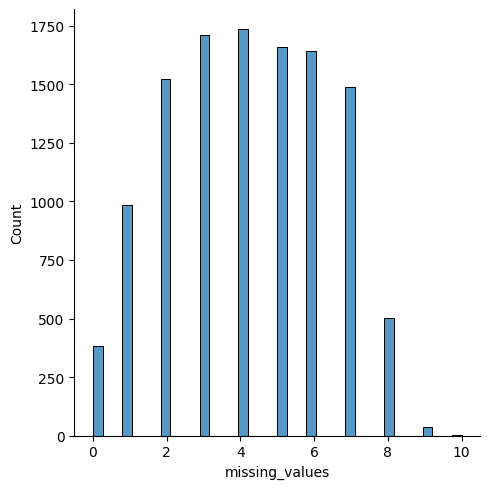

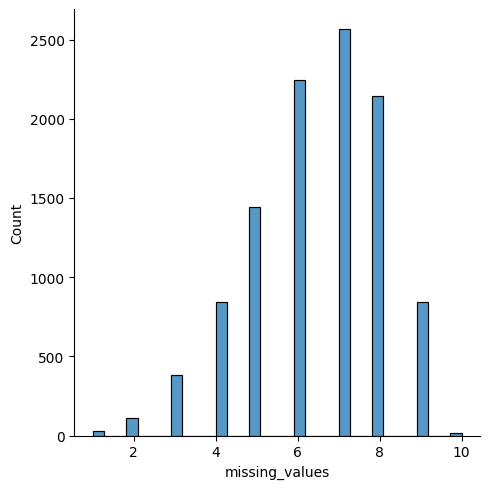

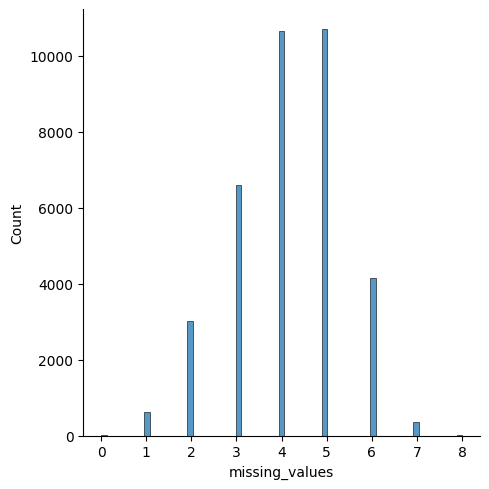

In [57]:
df_past.loc[(df_past["ownerships"].apply(lambda x:True if ((len(x)!=0 and x[0]=="not known") & (len(x)==2 and x[1]=="bootstrapped")) else False)),"ownerships"]="bootstrapped"

bootstraped=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"missing_values"]
not_known=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="not known" else False),"missing_values"]
subs=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="Subsidiary" else False),"missing_values"]

sns.displot(subs)
sns.displot(not_known)
sns.displot(bootstraped)



We see that the rows with "not known" as company status have alot of missing values. We will drop them in order to increase the explanatory value of the data (will not do for this iteration)

Further drop rows that have more missing values for a certain threshold

In [58]:
nothing=df_past.loc[df_past["Y"]==0,"missing_values"].describe()[["mean","std"]]
acquired=df_past.loc[df_past["Y"]=="acquired","missing_values"].describe()[["mean","std"]]
failed=df_past.loc[df_past["Y"]=="failed","missing_values"].describe()[["mean","std"]]
IPO=df_past.loc[df_past["Y"]=="IPO","missing_values"].describe()[["mean","std"]]
funding=df_past.loc[df_past["Y"]=="funding","missing_values"].describe()[["mean","std"]]
missing_df=pd.DataFrame([nothing,acquired,failed,IPO,funding])
missing_df.index=["nothing","acquired","failed","IPO","funding"]
missing_df

,mean,std
nothing,4.386213,1.752989
acquired,4.056175,2.147849
failed,5.357724,1.981777
IPO,4.473833,2.384615
funding,2.938376,1.703734


In [59]:
nothing_index=df_past.loc[(df_past["Y"]==0)&(df_past["missing_values"]>nothing[0]+0.5*nothing[1])].index
acquired_index=df_past.loc[(df_past["Y"]=="acquired")&(df_past["missing_values"]>acquired[0]+1.5*acquired[1])].index
failed_index=df_past.loc[(df_past["Y"]=="failed")&(df_past["missing_values"]>failed[0]+1.2*failed[1])].index
IPO_index=df_past.loc[(df_past["Y"]=="IPO")&(df_past["missing_values"]>IPO[0]+1.5*IPO[1])].index
funding_index=df_past.loc[(df_past["Y"]=="funding")&(df_past["missing_values"]>funding[0]+1.5*IPO[1])].index


In [60]:
df_past.drop(nothing_index,inplace=True)
df_past.drop(acquired_index,inplace=True)
df_past.drop(failed_index,inplace=True)
df_past.drop(IPO_index,inplace=True)
df_past.drop(funding_index,inplace=True)

In [61]:
x=df_past2.isna().sum()
y=df_past2.isna().sum()/len(df_past2)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                    Missing Values  In percent
name                             0    0.000000
about                            0    0.000000
website_url                      0    0.000000
facebook_url                 47762   67.194710
twitter_url                  23367   32.874226
linkedin_url                  2866    4.032077
total_funding                15955   22.446539
patents_count                    0    0.000000
employees_latest             41611   58.541080
launch_year                      0    0.000000
investors_total                  0    0.000000
fundings_total                 179    0.251829
country_name                     0    0.000000
city_name                        0    0.000000
industry_name                    0    0.000000
employees_growth             50911   71.624930
number_top_schools               0    0.000000
number_schools                   0    0.000000
team_male                     8735   12.288970
team_female                   8735   12.288970
avg_time_fund

# Delete all rows that are not desired

In [64]:
df_past2=df_past.drop(columns=["id","tagline","company_status","employees_chart","dealroom_signal","investors_items","team_items","company_status_past","Fin.Round.now","Fin.Round.past","fundings_items","team_universities","team_total","dealroom_signal","ownerships","cteam","founder_id","investor_names","founders_background","employees_growth","employees_latest"])

In [65]:
df_past2.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,is_bootstrapped,number_top_inv,missing_values
0,LNS,LNS brings over 45 years of proven experience ...,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,7,1973.0,1,0,Switzerland,Orvin,semiconductors,0,0,0,0,NaN,acquired,0,0,3
1,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000.0,0,2018.0,3,3,Switzerland,Renens,health,0,3,2,0,0.333333,failed,0,0,2
2,Stragen Chemical,Focusing on innovation for health solutions si...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0.0,0,1990.0,1,0,Switzerland,NaN,health,0,0,0,0,NaN,acquired,0,0,3
3,Smartseq,None,http://www.smartseq.it/,None,None,None,0.0,0,2013.0,2,0,Italy,NaN,food,0,0,0,0,NaN,acquired,0,0,7
5,PDFlib,None,http://pdflib.com,None,None,None,0.0,3,2000.0,1,0,Switzerland,NaN,media,0,0,0,0,NaN,acquired,0,0,7


## 1. Imputation for Categorical Values where imputation with numerical values doesnt make sense

1. City name 
2. Industry Name (will just drop the rows with empty values, (only 1140))
3. about (drop, only 1401)

1. City Name
- Will use the countries capital if not cities are associated with that country

In [66]:
city_names=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/Data/country-list.csv")
city_names.drop(columns="type",inplace=True)

In [67]:
country_index=df_past2.loc[pd.isnull(df_past2["country_name"])].index
df_past2.drop(country_index,inplace=True)

In [68]:
countries=pd.unique(df_past2["country_name"].values)
for i in countries:
    try:
        df_past2.loc[(df_past2["country_name"]==i)&(pd.isnull(df_past2["city_name"])),"city_name"]=df_past2.loc[df_past2["country_name"]==i,"city_name"].value_counts().idxmax()
    except:
        df_past2.loc[(df_past2["country_name"]==i)&(pd.isnull(df_past2["city_name"])),"city_name"]=city_names.loc[city_names["country"]==i,"capital"].values[0]

2. Industry Name

In [69]:
industry_index=df_past2.loc[df_past2["industry_name"].isna()].index
df_past2.drop(industry_index,inplace=True)

3. about

In [70]:
about_index=df_past2.loc[df_past2["about"].isna()].index
df_past2.drop(about_index,inplace=True)

See if Imputation has been succesfull

In [71]:
x=df_past2.isna().sum()
y=df_past2.isna().sum()/len(df_past2)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                    Missing Values  In percent
name                             0    0.000000
about                            0    0.000000
website_url                      0    0.000000
facebook_url                 46451   67.159691
twitter_url                  22614   32.695728
linkedin_url                  2669    3.858888
total_funding                11854   17.138726
patents_count                    0    0.000000
launch_year                      0    0.000000
investors_total                  0    0.000000
fundings_total                 155    0.224102
country_name                     0    0.000000
city_name                        0    0.000000
industry_name                    0    0.000000
number_top_schools               0    0.000000
number_schools                   0    0.000000
team_male                        0    0.000000
team_female                      0    0.000000
avg_time_funding              7709   11.145811
Y                                0    0.000000
is_bootstrapp

In [102]:
df_past2.to_pickle("df_past2_30.11")

In [8]:
df_past2=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_past2_30.11")

In [9]:
df_past2.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,employees_latest,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,employees_growth,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,missing_values,number_top_inv
0,LNS,LNS brings over 45 years of proven experience ...,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,7,27.0,1973.0,1,0,Switzerland,Orvin,semiconductors,0.080000,0,0,NaN,NaN,NaN,acquired,2,0
1,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000.0,0,NaN,2018.0,3,3,Switzerland,Renens,health,NaN,0,3,2.0,0.0,0.333333,failed,2,0
2,Stragen Chemical,Focusing on innovation for health solutions si...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0.0,0,118.0,1990.0,1,0,Switzerland,Orvin,health,-0.015919,0,0,0.0,0.0,NaN,acquired,3,0
4,Scoriff,Scoriff is a new-age business credit scoring c...,http://scoriff.com,https://www.facebook.com/scoriff,None,https://www.linkedin.com/company/scoriff/,NaN,0,NaN,2018.0,1,1,Denmark,Copenhagen,music,NaN,0,0,NaN,NaN,1.000000,0,7,1
6,Sajas Group,Sajas Group is a leading European brush compan...,https://www.sajas-group.com,None,https://twitter.com/envobrush,https://www.linkedin.com/company/sajas-group/,NaN,0,NaN,1945.0,1,1,Iceland,Reykjavík,fintech,NaN,0,0,NaN,NaN,75.000000,acquired,6,0


### Data Transformation

1. About (think about including the language model) (for now we only take the length of "good" words, meaning words except stop words etc)
2. country_name
3. city_name
4. industry_name
5. Y
6. launch_year (make years to now)
7. URL

In [72]:
nltk.download('stopwords')
def tokenizer(x:str):
    stop_words = set(stopwords.words('english'))
    tokens=word_tokenize(x)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens
    

[nltk_data] Downloading package stopwords to /Users/klaus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
df_past2.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,is_bootstrapped,number_top_inv,missing_values
0,LNS,LNS brings over 45 years of proven experience ...,http://lns-group.com,None,None,https://www.linkedin.com/company/lns-managemen...,0.0,7,1973.0,1,0,Switzerland,Orvin,semiconductors,0,0,0,0,NaN,acquired,0,0,3
1,ALAnostics,ALAnostics are a speciality Biopharmaceutical ...,https://alanostics.ch/,None,None,https://www.linkedin.com/company/alanostics/,60000.0,0,2018.0,3,3,Switzerland,Renens,health,0,3,2,0,0.333333,failed,0,0,2
2,Stragen Chemical,Focusing on innovation for health solutions si...,http://stragen.ch,None,https://twitter.com/stragenpharma,https://www.linkedin.com/company/stragenpharma,0.0,0,1990.0,1,0,Switzerland,Orvin,health,0,0,0,0,NaN,acquired,0,0,3
6,Sajas Group,Sajas Group is a leading European brush compan...,https://www.sajas-group.com,None,https://twitter.com/envobrush,https://www.linkedin.com/company/sajas-group/,NaN,0,1945.0,1,1,Iceland,Reykjavík,fintech,0,0,0,0,75.000000,acquired,0,0,6
7,Komatsu Germany,Komatsu Europe International n.v. (KEISA) are ...,http://komatsu.eu,None,None,https://www.linkedin.com/company/komatsu-europ...,0.0,0,2006.0,1,0,Germany,Munich,robotics,0,0,0,0,NaN,acquired,0,0,3


In [74]:
from nltk.corpus import stopwords

In [75]:
stop_words=set(stopwords.words('english'))

In [76]:
a=map(lambda p: tokenizer(p), df_past2["about"]) # remove stopwords and seperate str into list of words
df_past2["about"]=list(a)

a=map(lambda p: len([w.lower() for w in p if w.isalpha()]), df_past2["about"]) # remove all special signs and non alphabetic characters
df_past2["about"]=list(a)

2. Country_name

In [77]:
le=LabelEncoder()
label=le.fit_transform(df_past2.country_name)

df_past2["country_name"]=label

3. City_name

In [78]:
le=LabelEncoder()
label=le.fit_transform(df_past2.city_name)

df_past2["city_name"]=label

In [ ]:
4. Industry_name

In [79]:
le=LabelEncoder()
label=le.fit_transform(df_past2.industry_name)

df_past2["industry_name"]=label

6. Years

In [80]:
df_past2["launch_year"]=year_dif=2023-df_past2["launch_year"]

7. URL

In [81]:
df_past2["website_url"]=df_past2["website_url"].apply(lambda x:0 if x==None else 1)
df_past2["linkedin_url"]=df_past2["linkedin_url"].apply(lambda x:0 if x==None else 1)
df_past2["facebook_url"]=df_past2["facebook_url"].apply(lambda x:0 if x==None else 1)
df_past2["twitter_url"]=df_past2["twitter_url"].apply(lambda x:0 if x==None else 1)

5. Y
1- nothing happend
2- acquired
3- IPO
4- failed
5- received funding

In [82]:
df_past2.loc[df_past2["Y"]==0,"Y"]=0
df_past2.loc[df_past2["Y"]=="acquired","Y"]=1
df_past2.loc[df_past2["Y"]=="IPO","Y"]=2
df_past2.loc[df_past2["Y"]=="failed","Y"]=3
df_past2.loc[df_past2["Y"]=="funding","Y"]=4

# Imputation

1. total_funding (KNN) - maybe on evertyhing
2. employees latest (median)
3. team_male team_female (distribution)
4. employees_growth (0)
5. avg_time funding (KNN) - total_funding, fundings_total, launch year, country name, 
6. ? number of Schools ?


2. Employees_latest

In [83]:
df_past2 = df_past2.reset_index(drop=True)

In [84]:
from sklearn.impute import SimpleImputer
df_mode = df_past2.copy()
mode_imputer = SimpleImputer(strategy='median')
df_mode["employees_latest"] = mode_imputer.fit_transform(df_mode["employees_latest"].values.reshape(-1,1))


KeyError: 'employees_latest'

3. Team_male Team_female

In [85]:
df_mode = df_mode.reset_index(drop=True)

In [86]:
prob=df_mode["team_female"].sum()/df_mode["team_male"].sum()
df_mode["cteam"]=df_mode["team_male"]+df_mode["team_female"]
df_mode.loc[df_mode["cteam"]==0,"cteam"]=None
df_mode.loc[~(pd.isnull(df_mode["cteam"])),"cteam"]="Set"
#df_mode.loc[df_mode["cteam"]!=0,"cteam"]="Set"


In [89]:
df_mode.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,is_bootstrapped,number_top_inv,missing_values
0,LNS,28,1,0,0,1,0.0,7,50.0,1,0,19,27,18,0,0,1,0,NaN,1,0,0,3
1,ALAnostics,69,1,0,0,1,60000.0,0,5.0,3,3,19,30,7,0,3,2,0,0.333333,3,0,0,2
2,Stragen Chemical,130,1,0,1,1,0.0,0,33.0,1,0,19,27,7,0,0,1,0,NaN,1,0,0,3
3,Sajas Group,8,1,0,1,1,NaN,0,78.0,1,1,7,31,4,0,0,1,0,75.000000,1,0,0,6
4,Komatsu Germany,104,1,0,0,1,0.0,0,17.0,1,0,5,25,16,0,0,1,0,NaN,1,0,0,3


In [88]:
shape_df=df_mode.loc[df_mode["cteam"]!="Set","cteam"].shape

df_mode.loc[df_mode["cteam"]!="Set","cteam"]=np.random.choice(2, shape_df[0],p=[prob,1-prob])
df_mode.loc[df_mode["cteam"]==1,"team_male"]=1
df_mode.loc[df_mode["cteam"]==1,"team_female"]=0
df_mode.loc[df_mode["cteam"]==0,"team_female"]=1
df_mode.loc[df_mode["cteam"]==0,"team_male"]=0
df_mode.drop(columns=["cteam"],inplace=True)

In [90]:
shape_df

(37286,)

4. Employees_Growth

In [548]:
df_mode.loc[df_mode["employees_growth"].apply(lambda x: True if math.isnan(x) else False),"employees_growth"]=0

5. avg_time funding

Total funding / avg funding time

In [10]:
df_mode.loc[pd.isnull(df_mode["fundings_total"]),"fundings_total"]=0

In [119]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = df_mode.filter(['total_funding', 'fundings_total', 'launch_year', 'country_name',"avg_time_funding","launch_year","number_top_schools"], axis=1)
df_mice["fundings_total"]=pd.to_numeric(df_mice["fundings_total"])
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending', missing_values=np.nan, min_value = 0.0)
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [146]:
df_mice_imputed[df_mice_imputed["total_funding"]<0].shape

(0, 7)

In [121]:
df_mode["total_funding"]=df_mice_imputed["total_funding"].values
df_mode["avg_time_funding"]=df_mice_imputed["avg_time_funding"].values
df_mode.drop(df_mode.loc[df_mode["name"].isna()].index,inplace=True)


In [13]:
x=df_mode.isna().sum()
y=df_mode.isna().sum()/len(df_mode)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                    Missing Values  In percent
name                             0         0.0
about                            0         0.0
website_url                      0         0.0
facebook_url                     0         0.0
twitter_url                      0         0.0
linkedin_url                     0         0.0
total_funding                    0         0.0
patents_count                    0         0.0
launch_year                      0         0.0
investors_total                  0         0.0
fundings_total                   0         0.0
country_name                     0         0.0
city_name                        0         0.0
industry_name                    0         0.0
number_top_schools               0         0.0
number_schools                   0         0.0
team_male                        0         0.0
team_female                      0         0.0
avg_time_funding                 0         0.0
Y                                0         0.0
is_bootstrapp

In [96]:
df_mode.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,is_bootstrapped,number_top_inv,missing_values
0,LNS,28,1,0,0,1,0.000000e+00,7,50.0,1,0,19,27,18,0,0,1,0,22.067786,1,0,0,3
1,ALAnostics,69,1,0,0,1,6.000000e+04,0,5.0,3,3,19,30,7,0,3,2,0,0.333333,3,0,0,2
2,Stragen Chemical,130,1,0,1,1,0.000000e+00,0,33.0,1,0,19,27,7,0,0,1,0,14.892889,1,0,0,3
3,Sajas Group,8,1,0,1,1,2.995059e+07,0,78.0,1,1,7,31,4,0,0,1,0,75.000000,1,0,0,6
4,Komatsu Germany,104,1,0,0,1,0.000000e+00,0,17.0,1,0,5,25,16,0,0,1,0,7.969984,1,0,0,3


We need to transform the datatypes of the columns to numerical types for the ML models to be applicable

In [12]:
df_mode.dtypes

name                   object
about                   int64
website_url             int64
facebook_url            int64
twitter_url             int64
linkedin_url            int64
total_funding         float64
patents_count           int64
launch_year           float64
investors_total         int64
fundings_total        float64
country_name            int64
city_name               int64
industry_name           int64
number_top_schools      int64
number_schools          int64
team_male               int64
team_female             int64
avg_time_funding      float64
Y                       int64
is_bootstrapped         int64
number_top_inv          int64
missing_values          int64
dtype: object

In [9]:
df_mode["fundings_total"]=pd.to_numeric(df_mode["fundings_total"])
df_mode["Y"]=pd.to_numeric(df_mode["Y"])

In [76]:
df_mode.corr()

/var/folders/k0/ldv3tm456fl7jrgd0xn0vy5h0000gn/T/ipykernel_13139/2612738855.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mode.corr()


,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,launch_year,investors_total,fundings_total,country_name,city_name,industry_name,number_top_schools,number_schools,team_male,team_female,avg_time_funding,Y,is_bootstrapped,number_top_inv,missing_values
about,1.000000,NaN,0.059379,0.061044,-0.051197,0.008026,-0.000234,0.065090,-0.010973,0.014424,-0.000425,-0.000281,0.002201,-0.008837,-0.013770,-0.000426,-0.008393,0.031206,-0.017693,-0.026484,-0.011753,-0.035531
website_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facebook_url,0.059379,NaN,1.000000,0.326860,-0.026931,0.022983,0.006498,0.033821,0.093458,0.195364,-0.007461,-0.002650,-0.002212,-0.002156,0.003266,0.127650,0.017115,0.031396,-0.031734,-0.174495,0.057175,-0.151045
twitter_url,0.061044,NaN,0.326860,1.000000,0.026939,0.016382,0.008432,0.037053,0.134288,0.170700,0.000756,0.002010,0.000081,0.055153,0.088097,0.118979,0.015176,-0.003462,0.006551,-0.125552,0.070301,-0.222681
linkedin_url,-0.051197,NaN,-0.026931,0.026939,1.000000,0.000841,0.001496,-0.024205,0.024161,-0.039052,0.000534,-0.002664,-0.005185,0.062887,0.106800,0.014459,0.004654,-0.051775,-0.046478,0.132024,0.013367,-0.164174
total_funding,0.008026,NaN,0.022983,0.016382,0.000841,1.000000,0.007668,0.059982,0.027531,0.057398,0.000600,0.002031,-0.001776,0.008902,0.010922,0.003578,-0.006402,0.061508,0.015900,-0.046821,0.018656,-0.048452
patents_count,-0.000234,NaN,0.006498,0.008432,0.001496,0.007668,1.000000,0.051546,-0.001657,0.014925,0.003372,0.003300,-0.001832,0.005623,0.009525,-0.006421,0.003197,0.035207,0.008802,-0.010422,-0.002580,-0.009561
launch_year,0.065090,NaN,0.033821,0.037053,-0.024205,0.059982,0.051546,1.000000,-0.098532,-0.018944,0.001383,0.001181,0.000414,-0.013950,-0.026936,-0.092157,-0.022217,0.671821,-0.033019,-0.031903,-0.052850,0.009812
investors_total,-0.010973,NaN,0.093458,0.134288,0.024161,0.027531,-0.001657,-0.098532,1.000000,0.612147,0.006491,-0.003430,-0.005418,0.246058,0.300287,0.343197,0.062412,-0.016264,0.410962,-0.444626,0.379197,-0.406072
fundings_total,0.014424,NaN,0.195364,0.170700,-0.039052,0.057398,0.014925,-0.018944,0.612147,1.000000,0.008758,0.000423,-0.000901,0.166008,0.202910,0.329281,0.053014,0.067055,0.207542,-0.606730,0.252880,-0.385832


## Standardization

Columns to Standardize:
1. total_funding
2. employees_latest
3. employees_growth
4. avg time funding

In [53]:
# Creating the data frame
df_std=df_mode[["about","total_funding","employees_latest","employees_growth","avg_time_funding","missing_values","launch_year"]]
# define standard scaler
scaler = StandardScaler()
# transform data
df_std = scaler.fit_transform(df_std)
df_std=pd.DataFrame(df_std)
df_mode[["about","total_funding","employees_latest","employees_growth","avg_time_funding","missing_values","launch_year"]]=df_std.values

# Model Application

For The Model Application we are going to train models such that we receive an estimation of likelihood for each of the categories
- First step is to apply a model to the entired dataset and then see if we can improve on the score provided here. We will apply the Model xgboost as it has proven to give the best results for the comparison
- Model altercation for seperate variables
- Alternating between SMote and not


1. Models that should be tested
- KNN
- Gradien Boosting Trees
- Neural Networks

1. Model on the entire dataset

In [4]:
df_mode=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/df_mode_30.11")

In [3]:
df_mode.to_pickle("df_mode_30.11")

NameError: name 'df_mode' is not defined

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss


Categories 
0 - nothing happened
1 - acquired
2 - IPO
3 - failed
4 - funding


1. The following will be mostly experiences on variations of datasetup and models, with balancing, standardization.

In [134]:
X=df_mode.drop(columns=["name","Y"])
y=df_mode["Y"]

Without Smote

In [126]:

counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 4.078


With Smote

## 2. Predict funding

Get Data for funding (all vs. funding)

In [90]:
df_fund=df_mode.loc[(df_mode["Y"]==0) | (df_mode["Y"]==4)].copy()
df_fund.loc[(df_mode["Y"]==0),"Y"]=0 #compare it to companies where nothing happened 
df_fund.loc[(df_mode["Y"]==4),"Y"]=1
X=df_fund.drop(columns=["name","Y"])
y=df_fund["Y"]


In [160]:
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [238]:
sm = SMOTE(random_state = 2)
X,y = sm.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [45]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'max_delta_step': [0,1,2,4],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'min_child_weight': [1,2,3,4]}
xgbr = xgb.XGBClassifier()
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=10,
                         verbose=1)

In [46]:
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7999999999999999}
Lowest RMSE:  nan


/var/folders/k0/ldv3tm456fl7jrgd0xn0vy5h0000gn/T/ipykernel_13139/3937026439.py:3: RuntimeWarning: invalid value encountered in double_scalars
  print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))


In [157]:
fix_params= clf.best_params_
fix_params["objective"] = 'binary:logistic'

In [48]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(fix_params, xgdmat_train, num_boost_round = 100)

[20:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [26]:
import matplotlib.pyplot as plt 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    prec= tp/(tp+fp)
    rec= tp/(tp+fn)
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print("F-Score = {:.3e}".format((2*prec*rec)/(prec+rec)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

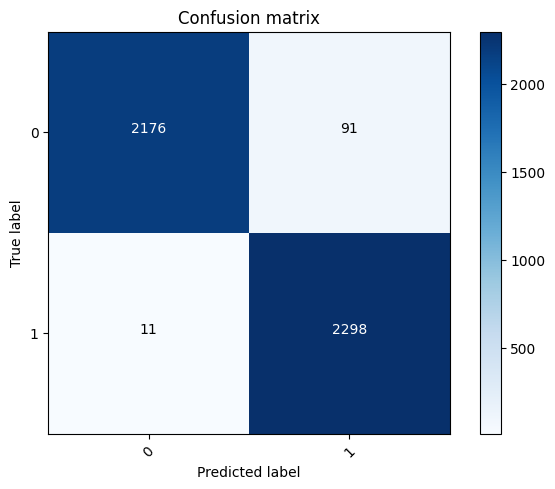

Precision =     0.962
Recall (TPR) =  0.995
Fallout (FPR) = 4.014e-02
F-Score = 9.783e-01


In [27]:
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [164]:
xgb_clf = xgb.XGBClassifier(**fix_params)
xgb_clf = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_proba= xgb_clf.predict_proba(X_test)


In [168]:
y_proba= xgb_clf.predict_proba(X_test)

In [170]:
y_proba[1:20]

array([[9.0968609e-04, 9.9909031e-01],
       [6.3061714e-05, 9.9993694e-01],
       [9.9824899e-01, 1.7509809e-03],
       [7.5960159e-04, 9.9924040e-01],
       [4.4107437e-05, 9.9995589e-01],
       [9.9951541e-01, 4.8461460e-04],
       [9.9943888e-01, 5.6111469e-04],
       [9.9974495e-01, 2.5505334e-04],
       [2.2414720e-01, 7.7585280e-01],
       [6.5306425e-03, 9.9346936e-01],
       [9.9796766e-01, 2.0323184e-03],
       [9.9732548e-01, 2.6744925e-03],
       [9.9634224e-01, 3.6577503e-03],
       [9.6097142e-01, 3.9028570e-02],
       [9.7571838e-01, 2.4281638e-02],
       [5.0799632e-01, 4.9200371e-01],
       [9.9818927e-01, 1.8107307e-03],
       [9.9987876e-01, 1.2122428e-04],
       [7.1123517e-01, 2.8876486e-01]], dtype=float32)

In [167]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2267
           1       0.98      0.99      0.98      2309

    accuracy                           0.98      4576
   macro avg       0.98      0.98      0.98      4576
weighted avg       0.98      0.98      0.98      4576



With Smote

In [127]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

Parameter Estimation
- all parameters:
- eta
- min_child_weight
- max_depth
- max_leaf_nodes
- gamma
- max_default_step
- subsample
- colsample_bytree
- colsample_bylevel
- lambda
- alpha
- scale_pos_weight
- n_estimators

In [128]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'max_delta_step': [0,1,2,4],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'min_child_weight': [1,2,3,4]}
xgbr = xgb.XGBClassifier()
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=5,
                         verbose=1)

In [ ]:
clf.fit(X_train_res, y_train_res)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [113]:
fix_params= clf.best_params_
fix_params["objective"] = 'binary:logistic'


In [114]:
xgdmat_train = xgb.DMatrix(X_train_res, y_train_res)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(fix_params, xgdmat_train, num_boost_round = 400)

[15:59:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [47]:
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [46]:

y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1)

NameError: name 'xgb_final' is not defined

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      7146
           1       0.30      0.96      0.46      1290

    accuracy                           0.65      8436
   macro avg       0.64      0.78      0.60      8436
weighted avg       0.88      0.65      0.70      8436



# Deep NLN

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import SWALR
from torch.optim import swa_utils
from torch.optim.lr_scheduler import CosineAnnealingLR

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
df_mode.columns

Index(['name', 'about', 'website_url', 'facebook_url', 'twitter_url', 'linkedin_url', 'total_funding', 'patents_count', 'launch_year', 'investors_total', 'fundings_total', 'country_name', 'city_name', 'industry_name', 'number_top_schools', 'number_schools', 'team_male', 'team_female', 'avg_time_funding', 'Y', 'is_bootstrapped', 'number_top_inv', 'missing_values'], dtype='object')

In [145]:
df_mode.isna().sum()

name                      0
about                     0
website_url               0
facebook_url              0
twitter_url               0
linkedin_url              0
total_funding             0
patents_count             0
launch_year               0
investors_total           0
fundings_total        33443
country_name              0
city_name                 0
industry_name             0
number_top_schools        0
number_schools            0
team_male                 0
team_female               0
avg_time_funding          0
Y                         0
is_bootstrapped           0
number_top_inv            0
missing_values            0
dtype: int64

In [197]:
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)

In [149]:
# Creating the data frame
df_stand=df_mode.copy()
df_std=df_stand.drop(columns=["name","Y"])
cols=df_std.columns
# define standard scaler
scaler = StandardScaler()
# transform data
df_std = scaler.fit_transform(df_std)
df_std=pd.DataFrame(df_std)
df_stand[cols]=df_std.values

df_fund=df_stand.copy()
df_fund.loc[(df_mode["Y"]!=4),"Y"]=0
df_fund.loc[(df_mode["Y"]==4),"Y"]=1
X=df_fund.drop(columns=["name","Y"])
y=df_fund["Y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#sm = SMOTE(random_state = 2)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [207]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_res.values), 
                       torch.FloatTensor(y_train_res))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test.values))

In [173]:
BATCH_SIZE=65
LEARNING_RATE=0.001
EPOCHS=25
SWA_START=10
WEIGHT_DECAY=0.001
LR_SWA=0.05


In [208]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [163]:
df_mode.shape

(69165, 23)

In [181]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(21, 65) 
        #self.layer_2 = nn.Linear(32, 65)
        self.layer_out = nn.Linear(65, 1) 
        
        self.relu = nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(65)
        #self.batchnorm2 = nn.BatchNorm1d(65)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        #x = self.relu(self.layer_2(x))
        #x = self.batchnorm2(x)

        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [176]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [209]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#optimizer = torch.optim.SGD(model.parameters(), LR)
#criterion = torch.nn.NLLLoss()


swa_model = swa_utils.AveragedModel(model)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
swa_scheduler = swa_utils.SWALR(optimizer, swa_lr=LR_SWA)


BinaryClassification(
  (layer_1): Linear(in_features=21, out_features=65, bias=True)
  (layer_out): Linear(in_features=65, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [178]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    
    return acc

In [179]:
def binary_rec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    fn_sum = ((y_pred_tag==0) & (y_test ==1)).sum().float()
    Recall=correct_results_sum/(correct_results_sum+fn_sum)
    Recall = torch.round(Recall * 100)
    
    return Recall

In [210]:

swa_model.train()
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        Recall = binary_rec(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += Recall.item()
       
 
    if e > SWA_START:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
    
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Recall : {epoch_rec/len(train_loader):.3f}')


Epoch 001: | Loss: 0.30911 | Acc: 87.030 | Recall : 94.309
Epoch 002: | Loss: 0.27075 | Acc: 88.871 | Recall : 95.075
Epoch 003: | Loss: 0.26242 | Acc: 89.303 | Recall : 95.311
Epoch 004: | Loss: 0.25491 | Acc: 89.673 | Recall : 95.451
Epoch 005: | Loss: 0.24811 | Acc: 90.052 | Recall : 95.652
Epoch 006: | Loss: 0.24718 | Acc: 90.089 | Recall : 95.752
Epoch 007: | Loss: 0.24541 | Acc: 90.139 | Recall : 95.775
Epoch 008: | Loss: 0.24364 | Acc: 90.222 | Recall : 95.840
Epoch 009: | Loss: 0.24098 | Acc: 90.332 | Recall : 95.868
Epoch 010: | Loss: 0.24016 | Acc: 90.361 | Recall : 95.930
Epoch 011: | Loss: 0.23951 | Acc: 90.414 | Recall : 95.976
Epoch 012: | Loss: 0.24779 | Acc: 90.036 | Recall : 95.708
Epoch 013: | Loss: 0.26333 | Acc: 89.270 | Recall : 95.296
Epoch 014: | Loss: 0.26908 | Acc: 88.987 | Recall : 95.150
Epoch 015: | Loss: 0.27403 | Acc: 88.806 | Recall : 95.003
Epoch 016: | Loss: 0.27670 | Acc: 88.822 | Recall : 95.036
Epoch 017: | Loss: 0.27902 | Acc: 88.658 | Recall : 94.9

In [211]:
torch.optim.swa_utils.update_bn(train_loader, swa_model)

In [212]:
y_pred_list = []
swa_model.eval()
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = swa_model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [213]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81      1503
           1       0.80      0.89      0.84      1548

    accuracy                           0.83      3051
   macro avg       0.83      0.83      0.83      3051
weighted avg       0.83      0.83      0.83      3051



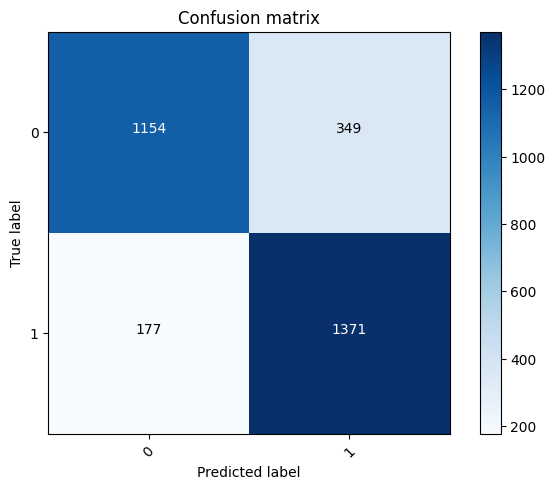

In [214]:
cm = confusion_matrix(y_test, y_pred_list)
plot_confusion_matrix(cm, ['0', '1'], )

KNN 

In [202]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_res, y_train_res)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      7146
           1       0.33      0.66      0.44      1290

    accuracy                           0.74      8436
   macro avg       0.63      0.71      0.63      8436
weighted avg       0.83      0.74      0.77      8436



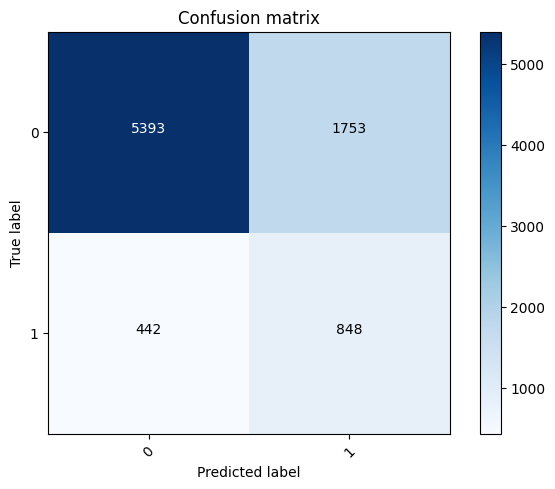

In [203]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )

In [56]:
pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 3.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Predicting Acquired, Failed IPO

XGBoost

In [173]:
df_fund=df_mode.loc[(df_mode["Y"]!=0) & (df_mode["Y"]!=4)].copy()
df_fund.loc[(df_mode["Y"]==1),"Y"]=0 #compare it to companies where nothing happened 
df_fund.loc[(df_mode["Y"]==2),"Y"]=1
df_fund.loc[(df_mode["Y"]==3),"Y"]=2
X=df_fund.drop(columns=["name","Y"])
y=df_fund["Y"]


In [18]:
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [174]:
sm = SMOTE(random_state = 2)
X,y = sm.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [175]:
Counter(y)

Counter({0: 11316, 2: 11316, 1: 11316})

In [171]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'max_delta_step': [0,1,2,4],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'min_child_weight': [1,2,3,4]}
xgbr = xgb.XGBClassifier()
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=2,
                         verbose=1)

In [176]:
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1136, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1277, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 20, 'max_delta_step': 0, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7999999999999999}
Lowest RMSE:  nan


In [179]:
fix_params= clf.best_params_
fix_params["objective"] = 'multi:softproba'
fix_params["num_class"]=3

In [180]:
xgb_clf = xgb.XGBClassifier(**fix_params)
xgb_clf = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_proba= xgb_clf.predict_proba(X_test)

In [34]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(fix_params, xgdmat_train, num_boost_round = 100)

[20:00:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [181]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2270
           1       0.93      0.92      0.93      2246
           2       0.97      0.94      0.96      2274

    accuracy                           0.93      6790
   macro avg       0.93      0.93      0.93      6790
weighted avg       0.93      0.93      0.93      6790

